In [0]:
!alias python='/usr/bin/python3.6'

In [4]:
import sys
import os

if "src" not in os.getcwd():
  !git clone --depth 1 https://inna_sukablyadova@bitbucket.org/inna_sukablyadova/runners_plate.git
  os.chdir('runners_plate/')
  sys.path.append('.')
else:
  !git pull

Cloning into 'runners_plate'...
remote: Counting objects: 56, done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 56 (delta 5), reused 0 (delta 0)
Unpacking objects: 100% (56/56), done.


In [0]:
!unzip samples.zip

full_pipe.ipynb  notebooks  src
k8s_configs	 README.md  step_by_step_demo.ipynb


/bin/bash: wich: command not found


In [0]:
import os
import numpy as np
import cv2

import requests
import pytesseract
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook

def plot(img, cmap=None):
    plt.rcParams['figure.figsize'] = (15, 15)
    plt.imshow(img, cmap)

### Read images

In [0]:
all_imgs = [i for i in os.listdir('samples/') if i.endswith('.jpg')]
print(f'{len(all_imgs)} images in folder')
# plot(all_imgs[4])

172 images in folder


### Request to human detector

In [0]:
!pip 

full_pipe.ipynb  notebooks  src
k8s_configs	 README.md  step_by_step_demo.ipynb


In [0]:
from src.human_detector_service.tensorflow_human_detection import DetectorAPI

In [0]:
model_path = 'src/human_detector_service/models/faster_rcnn_inception_v2_coco_2018_01_28/frozen_inference_graph.pb'
odapi = DetectorAPI(path_to_ckpt=model_path)
threshold = 0.7

name = all_imgs[6]
img = cv2.cvtColor(cv2.imread(f'samples/{name}'), cv2.COLOR_BGR2RGB)
plot(n_img)

shape = img.shape[1], img.shape[0]
img = cv2.resize(img, (1280, 720))

boxes, scores, classes, num = odapi.processFrame(img)
# Visualization of the results of a detection.

for i in range(len(boxes)):
    # Class 1 represents human
    if classes[i] == 1 and scores[i] > threshold:
        box = boxes[i]
        cv2.rectangle(img, (box[1], box[0]), (box[3], box[2]), (255, 0, 0), 2)

    img = cv2.resize(img, shape)

AttributeError: ignored

200

Detected 1 humans in Marathon_Women_running-1200x628-facebook_0.jpg image


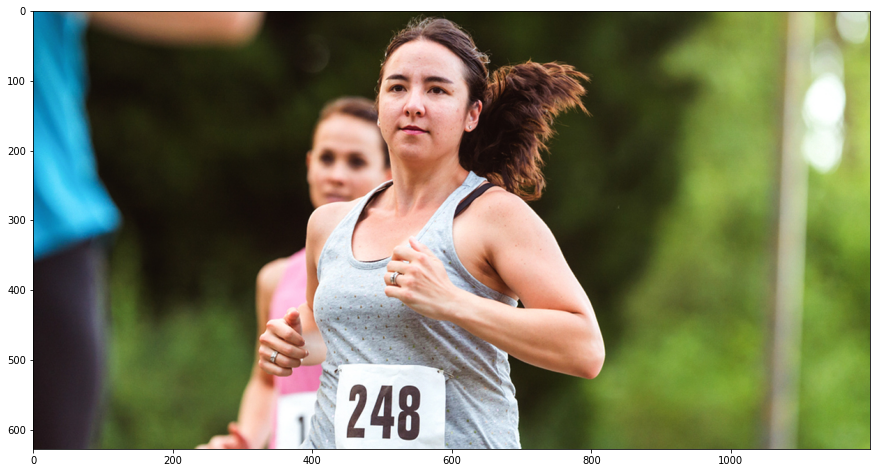

In [0]:
name = all_imgs[6]
img = open(f'samples/{name}', 'rb').read()
n_img = cv2.cvtColor(cv2.imread(f'samples/{name}'), cv2.COLOR_BGR2RGB)
plot(n_img)

r = requests.post('http://localhost:3450/', files={'image': img})

print(r.status_code)
# print(r.json())
cont = r.json()
# rectangles from human detector
humans = []
for cnt in cont:
    y_l = cnt[0]
    x_l = cnt[1]
    y_r, x_r = cnt[2:]
    
    cropped_human = n_img.copy()[y_l: y_r, x_l: x_r]
    humans.append(cropped_human)

print(f'\nDetected {len(humans)} humans in {name} image')

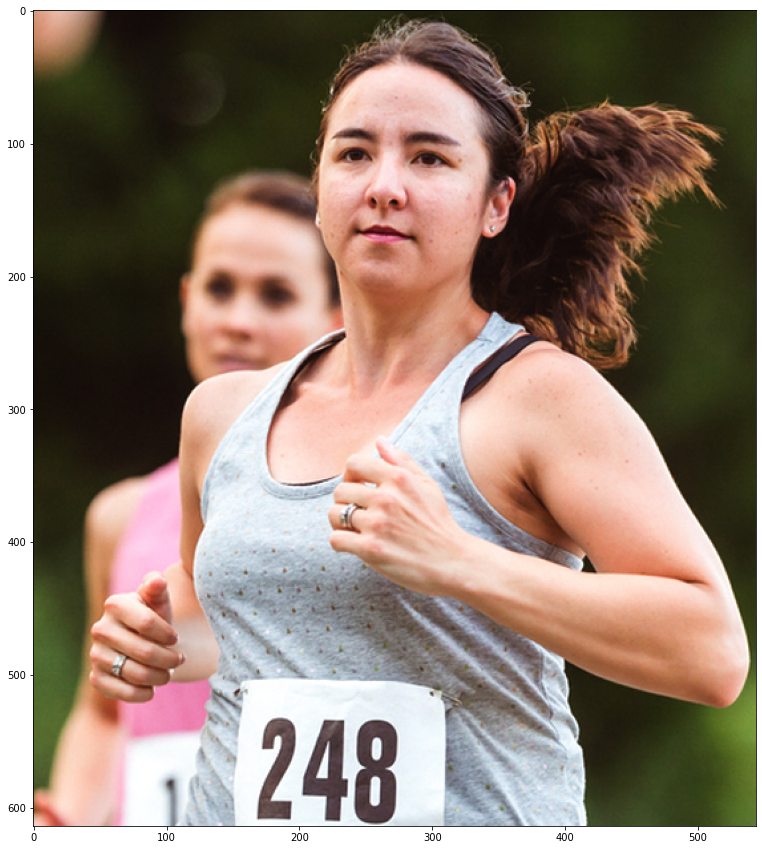

<Figure size 1080x1080 with 0 Axes>

In [0]:
# check humans
for i in humans:
    plot(i)
    plt.figure()

### Detect text on humans

In [0]:
from src.text_detector.text_detector import detect, crop

In [0]:
test = humans[1]
boxes, text_on = detect(test.copy())


# for bbox in boxes:
#     bbox = np.reshape(bbox, (4, 2))
#     cv2.drawContours(test, [bbox], -1, (0, 255, 0), 2)
    
plot(test)

IndexError: list index out of range

In [0]:
boxed = []
text_save_path = 'src/text_recognition/cropped_text/'
!rm -rf {text_save_path}
!mkdir {text_save_path}

human_counter = 0
for test in tqdm_notebook(humans):
    h, w, c = test.shape
    boxes, text_on = detect(test.copy())
    # get detected text from humans
    for i, box in enumerate(boxes):
        cropped_text = crop(test.copy(), box)
        try:
            cv2.imwrite(f'{text_save_path}{human_counter}_{i}_{name}', cropped_text)
        except:
            print(f'Trouble with image {human_counter}_{i}_{name}')

/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/torch/nn/functional.py:2796: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/Users/cheena/PycharmProjects/runners_plate/venv/lib/python3.6/site-packages/torch/nn/functional.py:2973: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


### Recognize text

In [0]:
output = !CUDA_VISIBLE_DEVICES=0 python3 src/text_recognition/demo.py \
--Transformation TPS --FeatureExtraction ResNet --SequenceModeling BiLSTM --Prediction Attn \
--image_folder {text_save_path} \
--saved_model  src/text_recognition/model/TPS-ResNet-BiLSTM-Attn.pth


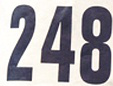

In [0]:
from IPython.core.display import display, HTML
from PIL import Image
import base64
import io
import pandas as pd

def postprocessing(text) -> str:
    changed_text = text
    changed_text = [str(s) for s in changed_text if s.isdigit()]
    if len(changed_text) > 1:
        return ''.join(changed_text)
    else:
        return False

data = pd.DataFrame()
for ind, row in enumerate(output[output.index('image_path               \tpredicted_labels         \tconfidence score')+2:]):
    row = row.split('\t')
    filename = row[0].strip()
    label = row[1].strip()
    label = postprocessing(label)
    conf = row[2].strip()
    if float(conf) > 0.7 and label:
        img = Image.open(filename)
        img_buffer = io.BytesIO()
        img.save(img_buffer, format="PNG")
        imgStr = base64.b64encode(img_buffer.getvalue()).decode("utf-8") 

        data.loc[ind, 'img'] = '<img src="data:image/png;base64,{0:s}">'.format(imgStr)
        data.loc[ind, 'id'] = filename
        data.loc[ind, 'label'] = label
        data.loc[ind, 'conf'] = conf

html_all = data.to_html(escape=False)
display(HTML(html_all))